In [1]:
import re
import os
import pysolr
import tabulate
from datetime import datetime
from pprint import pprint
from IPython.display import HTML, display

# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)


In [2]:
# Solr collection url 
SOLR_URL = 'http://solr:8983/solr/cmp269'

QUERIES_FILE_PATH = 'data/Consultas_UTF8.txt'

## Código pra ler os arquivos e separar as queries com base nas tags

In [3]:
def parse_file(fpath, doc_tag):
    '''Reads file line by line and extract the docs'''

    docs = []
    closing_doc_line = "</%s>\n" % doc_tag
    
    with open(fpath) as file:
        doc_as_string = ""

        line = file.readline()
        while (line):
            if (line) == closing_doc_line:
                doc_as_string += line
                
                doc = parse_doc(doc_as_string)
                docs.append(doc)

                doc_as_string = ""
            else:
                doc_as_string += line

            line = file.readline()

    return docs

## Código para fazer o parse da string de cada query e criar um dicionário

In [4]:
def parse_doc(doc_as_string):
    # print(doc_as_string)

    doc_tpl = {
        'num': 'num',
        'PT-title': 'title',
        'PT-desc': 'desc',
        'PT-narr': 'narr',
    }

    doc = {}

    for key in doc_tpl.keys():
        # generates something like:
        # str_pattern = ".*\<DOCID\>(.*)\<\/DOCID\>.*"
        str_pattern = ".*\<%s\>(.*)\<\/%s\>.*" % (key, key)

        # compiles pattern, capture match, updates doc
        re_pattern = re.compile(str_pattern, re.DOTALL)
        match = re_pattern.match(doc_as_string)
        
        if match:
            value = match.group(1).strip()
            solr_key = doc_tpl[key]
            doc.update({solr_key: value})

    # ensures we have all keys..
    for key in doc_tpl.values():
        assert(doc[key] is not None)

    return doc


In [5]:
sq = pysolr.Solr(SOLR_URL)

queries = parse_file(QUERIES_FILE_PATH, 'top')

pprint(queries[0])

{'desc': 'Encontrar documentos sobre tratamentos que empreguem medicina '
         'natural ou alternativa. Aqui são incluídas terapias como a '
         'acupuntura, a hemopatia, a quiroprática, entre outras.',
 'narr': 'Documentos relevantes devem fornecer informação, específica ou '
         'genérica, sobre o uso de tratamentos ou técnicas de medicina '
         'natural ou alternativa.',
 'num': '251',
 'title': 'Medicina alternativa'}


## Testando várias maneiras diferentes de fazer a query na API do Solr...

In [6]:
def query(params):
    result = sq.search(**params)
    result_lines.append([result.hits, params])


sq = pysolr.Solr(SOLR_URL)


queries = parse_file(QUERIES_FILE_PATH, 'top')

# Vamos testar só com as duas primeiras
queries = queries[:2]

for q in queries:
    
    result_lines = []
    title = q["title"]

    # query inteira e entre aspas, precedida pelo nome do campo ("text_txt_pt:")
    quoted_query = 'text_txt_pt:"%s"' % title

    # cada termo da query precedido pelo nome do campo
    parts = ["text_txt_pt:%s" % p for p in title.split(' ')]
    unquoted_query = '%s' % ' '.join(parts)

    # cada termo da query precedido por "+text_txt_pt:" (repare o sinal +)
    parts = ["+text_txt_pt:%s" % p for p in title.split(' ')]
    plus_query = '%s' % ' '.join(parts)

    
    # default field
    default_field = "text_txt_pt"
    
    # query inteira e entre aspas (sem o nome do campo)
    quoted_query_df = '"%s"' % title

    # query inteira e sem as aspas
    unquoted_query_df = title

    # cada termo da query precedido só pelo sinal de +
    parts = ["+%s" % p for p in title.split(' ')]
    plus_query_df = '%s' % ' '.join(parts)


    # cabeçalho da tabela
    result_lines.append([None, title])
    result_lines.append(['# Results', 'Parameters'])

    ##
    ## Usando o parâmetro query 
    ##
    query({
        "q": quoted_query
    })

    query({
        "q": unquoted_query,
        "q.op": "OR"
    })
    
    query({
        "q": unquoted_query,
        "q.op": "AND"
    })

    query({
        "q": plus_query
    })


    # linha em branco na tabela
    result_lines.append([None,None])

    ##
    ## Usando filter query
    ##
    query({
        "q": "*:*",
        "fq": quoted_query
    })

    query({
        "q": "*:*",
        "q.op": "OR",
        "fq": unquoted_query,
    })

    query({
        "q": "*:*",
        "q.op": "AND",
        "fq": unquoted_query,
    })

    query({
        "q": "*:*",
        "fq": plus_query,
    })


    # linha em branco na tabela
    result_lines.append([None,None])

    ##
    ## Usando default field
    ##

    query({
        "q": quoted_query_df,
        "df": default_field,
    })

    query({
        "q": unquoted_query_df,
        "q.op": "OR",
        "df": default_field,
    })

    query({
        "q": unquoted_query_df,
        "q.op": "AND",
        "df": default_field,
    })
    
    query({
        "q": plus_query_df,
        "df": default_field,
    })

    display(HTML(tabulate.tabulate(result_lines, tablefmt='html')))

print("The end")

,Medicina alternativa
# Results,Parameters
2,"{'q': 'text_txt_pt:""Medicina alternativa""'}"
2616,"{'q': 'text_txt_pt:Medicina text_txt_pt:alternativa', 'q.op': 'OR'}"
41,"{'q': 'text_txt_pt:Medicina text_txt_pt:alternativa', 'q.op': 'AND'}"
41,{'q': '+text_txt_pt:Medicina +text_txt_pt:alternativa'}
,
2,"{'q': '*:*', 'fq': 'text_txt_pt:""Medicina alternativa""'}"
2616,"{'q': '*:*', 'q.op': 'OR', 'fq': 'text_txt_pt:Medicina text_txt_pt:alternativa'}"
41,"{'q': '*:*', 'q.op': 'AND', 'fq': 'text_txt_pt:Medicina text_txt_pt:alternativa'}"
41,"{'q': '*:*', 'fq': '+text_txt_pt:Medicina +text_txt_pt:alternativa'}"


,Sistemas de reforma e pensões na Europa
# Results,Parameters
0,"{'q': 'text_txt_pt:""Sistemas de reforma e pensões na Europa""'}"
11409,"{'q': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa', 'q.op': 'OR'}"
0,"{'q': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa', 'q.op': 'AND'}"
0,{'q': '+text_txt_pt:Sistemas +text_txt_pt:de +text_txt_pt:reforma +text_txt_pt:e +text_txt_pt:pensões +text_txt_pt:na +text_txt_pt:Europa'}
,
0,"{'q': '*:*', 'fq': 'text_txt_pt:""Sistemas de reforma e pensões na Europa""'}"
11409,"{'q': '*:*', 'q.op': 'OR', 'fq': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa'}"
0,"{'q': '*:*', 'q.op': 'AND', 'fq': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa'}"
0,"{'q': '*:*', 'fq': '+text_txt_pt:Sistemas +text_txt_pt:de +text_txt_pt:reforma +text_txt_pt:e +text_txt_pt:pensões +text_txt_pt:na +text_txt_pt:Europa'}"


The end


## Escolhendo um jeito...

Dá pra ver que há vários jeitos de fazer a mesma query...
Escolhendo uma das opções que traz pelo menos um resultado ambas as queries:

* Sem aspas
* Usando o operador OR
* Indicando o default_field

Ex:

```python
{
    'df': 'text_txt_pt', 
    'q': 'Centrais nucleares', 
    'q.op': 'OR'
}
```




In [7]:
sq = pysolr.Solr(SOLR_URL)

result_lines = []
result_lines.append(['# Results', 'query'])

queries = parse_file(QUERIES_FILE_PATH, 'top')
for q in queries:

    title = q["title"]

    params = {
        "q": title,
        "q.op": "OR",
        "df": "text_txt_pt",
    }
    
    result = sq.search(**params)
    result_lines.append([result.hits, title])
    
    result = None
    
display(HTML(tabulate.tabulate(result_lines, tablefmt='html')))

print("The end")

# Results,query
2616,Medicina alternativa
11409,Sistemas de reforma e pensões na Europa
10121,Países com pena de morte
1406,Danos provocados por terramotos
964,Viciados na Internet
1218,Doença de Creutzfeldt-Jakob
1209,Limpeza étnica nos Balcãs
1940,Legislação anti-tabagista
12,Adivinhação
2,Espectáculos de beneficiência


The end


##Fazendo a mesma query em campos com pré-processamentos distintos

In [8]:
sq = pysolr.Solr(SOLR_URL)

fields = ['text_txt_c1', 'text_txt_c2', 'text_txt_c3', 'text_txt_c4',
          'text_txt_c5', 'text_txt_c6', 'text_txt_c7', 'text_txt_pt',]

cols = ['Query title'] + fields

result_lines = []
#result_lines.append(['Query title'])
# result_lines.append(['Query title'] + fields)
#
queries = parse_file(QUERIES_FILE_PATH, 'top')
for q in queries:
    title = q["title"]
    result_line = [title]
    
    for field in fields:
        params = {
            "q": title,
            "q.op": "OR",
            "df": field,
        }

        result = sq.search(**params)
        result_line.append(result.hits)

    result_lines.append(result_line)
    result = None
    
#display(HTML(tabulate.tabulate(result_lines, tablefmt='html')))

df = pd.DataFrame(data=result_lines, columns=cols)
df_indexed = df.set_index('Query title')

df_indexed

,text_txt_c1,text_txt_c2,text_txt_c3,text_txt_c4,text_txt_c5,text_txt_c6,text_txt_c7,text_txt_pt
Query title,,,,,,,,
Medicina alternativa,1468,1787,1787,2616,2616,2616,2616,2616
Sistemas de reforma e pensões na Europa,52004,52007,6038,11409,11409,14097,14742,11409
Países com pena de morte,51836,51848,8060,10121,10130,10323,10507,10121
Danos provocados por terramotos,36245,37062,518,1406,1459,1612,1614,1406
Viciados na Internet,40495,41554,803,964,964,964,964,964
Doença de Creutzfeldt-Jakob,51728,51741,827,1218,1218,1218,1218,1218
Limpeza étnica nos Balcãs,18697,19880,771,1209,1209,1210,1741,1209
Legislação anti-tabagista,439,1900,1900,1940,1940,1941,9235,1940
Adivinhação,0,11,11,12,12,12,12,12


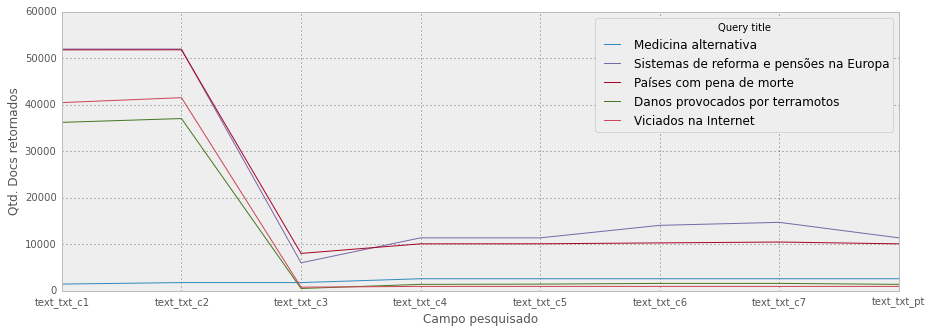

In [9]:
graph = df_indexed[:5].T.plot()

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Campo pesquisado")

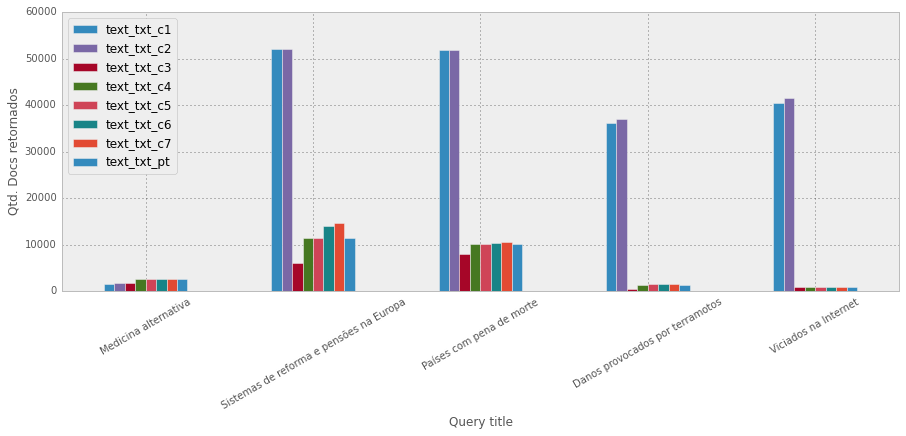

In [10]:
graph = df_indexed[:5].plot(kind='bar', rot=30)

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Query title")

In [61]:
def compute_variation(results):
    print(results)
    print("--")
    return
    desc = results.describe()
    variation = max(desc.T["max"]) - min(desc.T["min"])
    return variation

new_df = df.copy()
new_df.loc[:, "variation"] = compute_variation(df)

                                       Query title  text_txt_c1  text_txt_c2  text_txt_c3  text_txt_c4  text_txt_c5  text_txt_c6  text_txt_c7  text_txt_pt
0                             Medicina alternativa         1468         1787         1787         2616         2616         2616         2616         2616
1          Sistemas de reforma e pensões na Europa        52004        52007         6038        11409        11409        14097        14742        11409
2                         Países com pena de morte        51836        51848         8060        10121        10130        10323        10507        10121
3                  Danos provocados por terramotos        36245        37062          518         1406         1459         1612         1614         1406
4                             Viciados na Internet        40495        41554          803          964          964          964          964          964
5                      Doença de Creutzfeldt-Jakob        51728       